In [1]:
## Overlap louvain cluster with markers from a previous AllMarkers Table
## Demonstrate Subset of Aging Data Set (used for Tutorial in Dez 2019) and Galapagos Test Data
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
from ma_codes import mysize

sc.settings.verbosity = 3               # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_version_and_date()

Running Scanpy 1.5.1, on 2020-07-26 12:30.


In [2]:
## Set global plotting parameters
#sc.set_figure_params(vector_friendly = True)
plt.rcParams["figure.figsize"] = (6, 5)

### [Update] Example 1: On Galapagos Test Data (Bleo vs. PBS Mice)

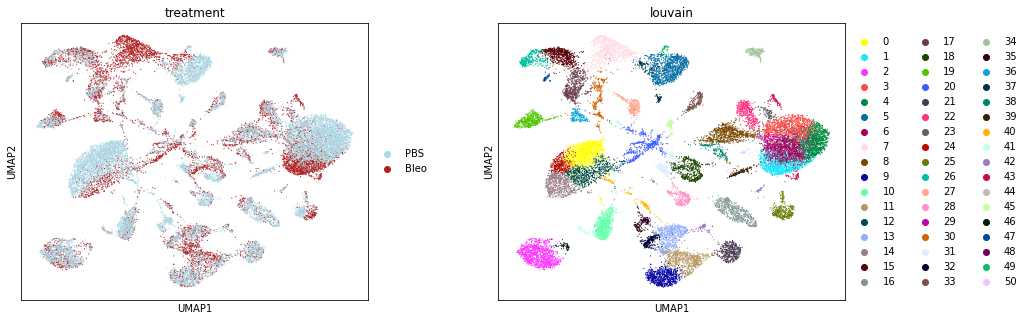

In [3]:
object_folder = "/mnt/platte_1/Projects/200715_GLPG_Training/"
adata = sc.read(object_folder + "200724_GLPG_Training_souped_MA.h5ad")
sc.pl.umap(adata, color = ["treatment", "louvain"], wspace = 0.25)

### Calculate Marker Genes of the Cluster

In [5]:
sc.tl.rank_genes_groups(adata, groupby = "louvain")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


### Read in previous Marker Genes Table (use new final Table from Particle Project)

In [6]:
marker_folder = "/home/agando/Documents/GitHub/Code_Repository/Python/output/"
marker_table = pd.read_csv(marker_folder + "Particle_AllMarkers.txt", sep = "\t", index_col = None)
marker_table.head(4)

,gene,score,logfoldchange,pval,pval_adj,cluster
0,Chil3,113.772710,7.300887,0.0,0.0,AM
1,Ccl6,101.765170,5.722293,0.0,0.0,AM
2,Ctsd,98.333850,4.668608,0.0,0.0,AM
3,Ctss,93.288345,3.988100,0.0,0.0,AM


In [7]:
## Restrict to Foldchange and P value
marker_table = marker_table[(marker_table.logfoldchange > 2) & (marker_table.pval_adj < 0.05)].copy()
print(marker_table.shape)

marker = dict()
for ct in marker_table["cluster"].unique():
    tmp = marker_table[marker_table["cluster"] == ct]
    marker[ct] = tmp.gene.values

(8238, 6)


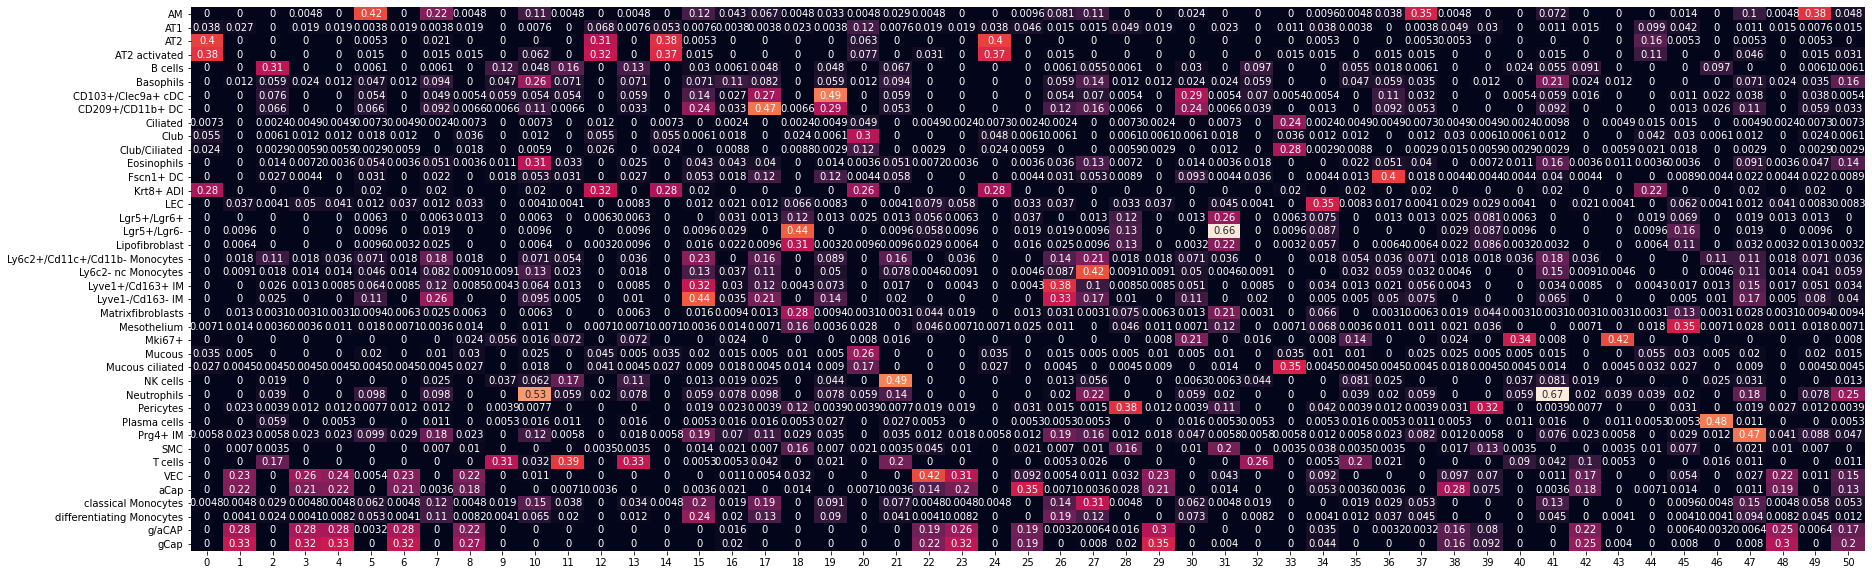

In [8]:
## Look at a predefined list of cell types and the corresponding marker genes in order to annotate our clusters
cell_annotation = sc.tl.marker_gene_overlap(adata, marker, key = 'rank_genes_groups', normalize = 'reference')

fig, ax = plt.subplots(figsize = (30, 10))
sb.heatmap(cell_annotation, cbar = False, annot = True)

... storing 'cell_type' as categorical


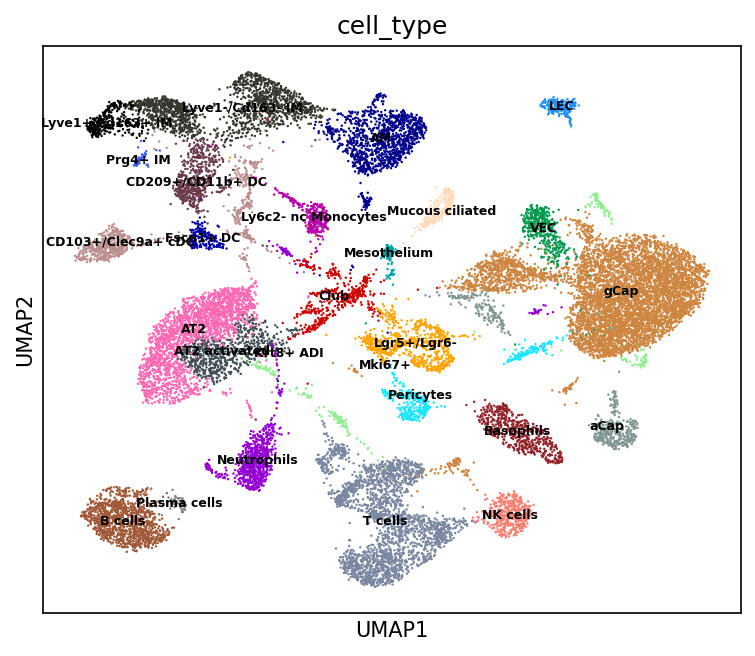

In [9]:
## Assign each louvain cluster to the reference cluster to which it has the highest overlap
cell_type = dict()
for col in cell_annotation.columns:
    cell_type[col] = cell_annotation.index.values[np.argmax(cell_annotation.loc[:, col])]
    
## Alternatively, manually set cell types dictionary
#  cell_type = {'0': 'Type_2_pneumocytes', '1': 'Alveolar_macrophage', '2': 'Type_2_pneumocytes',
#               '3': 'Club_cells', '4': 'Cd4+_T_cells', '5': 'B_cells', '6': 'Ciliated_cells', etc...}

adata.obs["cell_type"] = [cell_type[cluster] for cluster in adata.obs["louvain"]]
sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", ax = mysize(6, 5, 150), legend_fontsize = 6)

### Manually change some cluster labels

... storing 'cell_type' as categorical


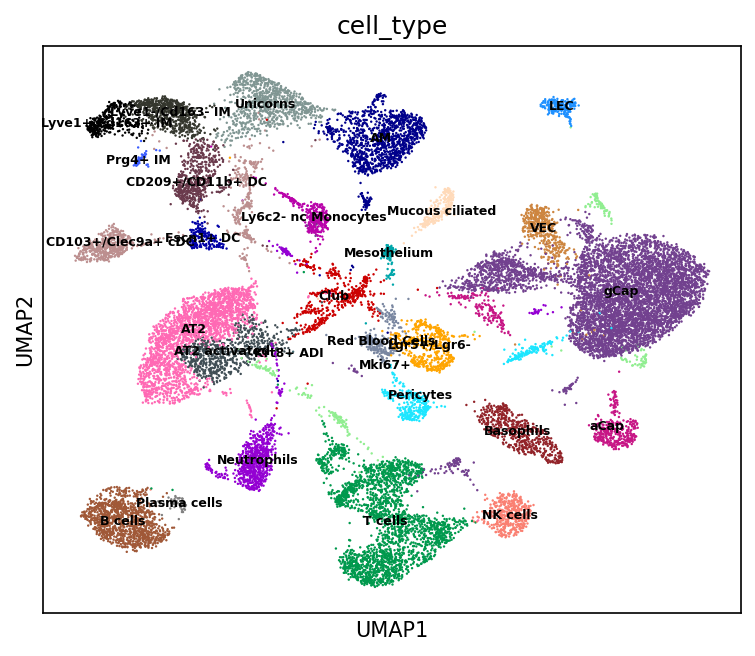

In [13]:
## E.g. change louvain cluster 7, 31 and to something else
## Those louvain cluster which are not specified, will keep their previous automated cell type annotation
cell_types = {"31": "Red Blood Cells", "7": "Unicorns"}
adata.obs["cell_type"] = [cell_types[l] if l in cell_types.keys() else ct
                          for l, ct in zip(adata.obs["louvain"], adata.obs["cell_type"])]
sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", ax = mysize(6, 5, 150), legend_fontsize = 6)

### Example 2: On Aging Subset from Elite Tutorial

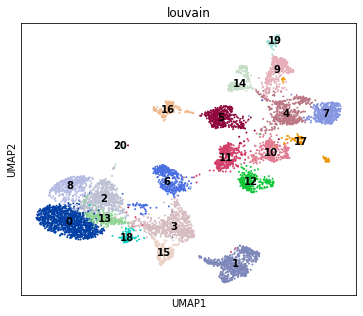

In [3]:
adata = sc.read("/media/agando/578222DA06535F39/Data_Objects/Scanpy_Objects/191014_Aging.h5ad")
sc.pl.umap(adata, color = "louvain", legend_loc = 'on data')

### Calculate Marker Genes of the Cluster

In [4]:
sc.tl.rank_genes_groups(adata, groupby = "louvain")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


### Read in previous Marker Genes Table
### 1) Aging All Markers

In [5]:
folder = "/home/agando/Documents/GitHub/Code_Repository/Python/output/"
marker_table = pd.read_csv(folder + "Aging_AllMarkers_per_celltype.txt", sep = "\t", index_col = 0)
marker_table.head()

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
1,0.0,2.815113,0.968,0.214,0.0,Alveolar_macrophage,Chi3l3
2,0.0,2.564033,0.924,0.205,0.0,Alveolar_macrophage,Ccl6
3,0.0,2.465148,0.641,0.050,0.0,Alveolar_macrophage,Ear2
4,0.0,2.284334,0.553,0.032,0.0,Alveolar_macrophage,Atp6v0d2
5,0.0,2.038324,0.549,0.056,0.0,Alveolar_macrophage,Mrc1


In [6]:
## Restrict to Foldchange and P value
marker_table = marker_table[(marker_table.avg_logFC > 0.5) & (marker_table.p_val_adj < 0.05)].copy()
print(marker_table.shape)

marker = dict()
for ct in marker_table["cluster"].unique():
    tmp = marker_table[marker_table["cluster"] == ct]
    marker[ct] = tmp.gene.values

(6810, 7)


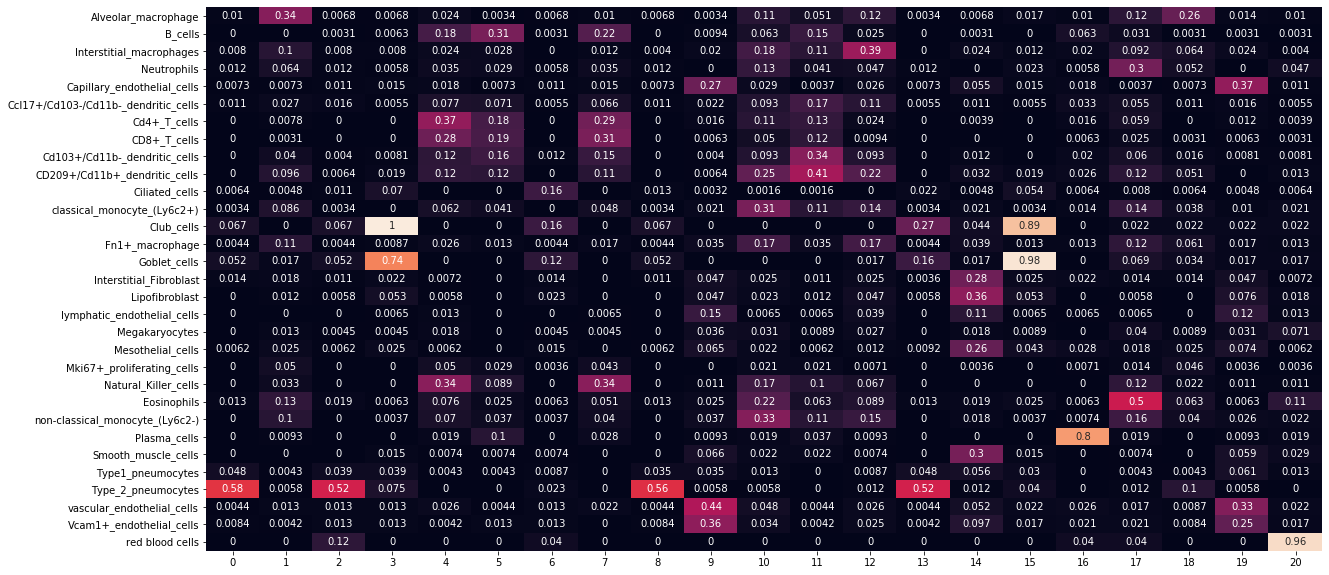

In [7]:
## Look at a predefined list of cell types and the corresponding marker genes in order to annotate our clusters
cell_annotation = sc.tl.marker_gene_overlap(adata, marker, key = 'rank_genes_groups', normalize = 'reference')

fig, ax = plt.subplots(figsize = (20, 10))  ## change figure size here
sb.heatmap(cell_annotation, cbar = False, annot = True)

... storing 'cell_type' as categorical


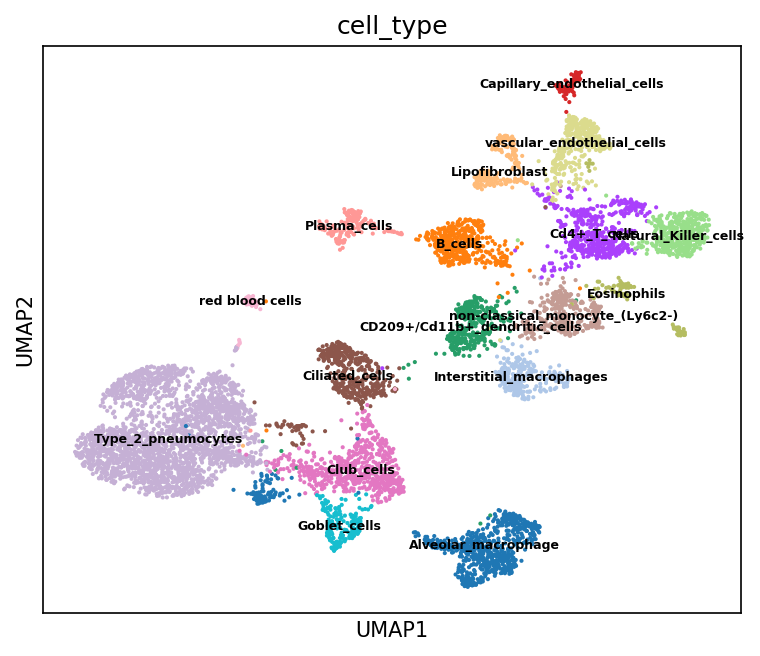

In [8]:
cell_type = dict()
for col in cell_annotation.columns:
    cell_type[col] = cell_annotation.index.values[np.argmax(cell_annotation.loc[:, col])]
    
## Alternatively, manually set cell types dictionary
#  cell_type = {'0': 'Type_2_pneumocytes', '1': 'Alveolar_macrophage', '2': 'Type_2_pneumocytes',
#               '3': 'Club_cells', '4': 'Cd4+_T_cells', '5': 'B_cells', '6': 'Ciliated_cells', etc...}

adata.obs["cell_type"] = [cell_type[cluster] for cluster in adata.obs["louvain"]]
sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", ax = mysize(6, 5, 150), legend_fontsize = 6)

### 2) Bleo whole Lung All Markers

In [9]:
folder = "/home/agando/Documents/GitHub/Code_Repository/Python/output/"
marker_table = pd.read_excel(folder + "Bleo_AllMarkers_per_celltype.xlsx")
marker_table.head()

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene,cell type
0,0.0,5.335429,0.576,0.076,0.0,30,Igha,Plasma cells
1,0.0,5.185098,0.881,0.156,0.0,30,Igkc,Plasma cells
2,0.0,4.931945,0.928,0.088,0.0,27,Scgb3a1,Goblet cells
3,0.0,4.896008,0.811,0.029,0.0,30,Igj,Plasma cells
4,0.0,4.728458,0.847,0.039,0.0,20,S100a9,Neutrophil granulocytes


In [10]:
## Restrict to Foldchange and P value
marker_table = marker_table[(marker_table.avg_logFC > 0.5) & (marker_table.p_val_adj < 0.05)].copy()
print(marker_table.shape)

marker = dict()
for ct in marker_table["cell type"].unique():
    tmp = marker_table[marker_table["cell type"] == ct]
    marker[ct] = tmp.gene.values

(7227, 8)


/home/agando/Documents/Meshal/python_packages/scanpy/scanpy/tools/_marker_gene_overlap.py:254: RuntimeWarning: invalid value encountered in true_divide
  marker_match = marker_match / ref_lengths[:, np.newaxis]


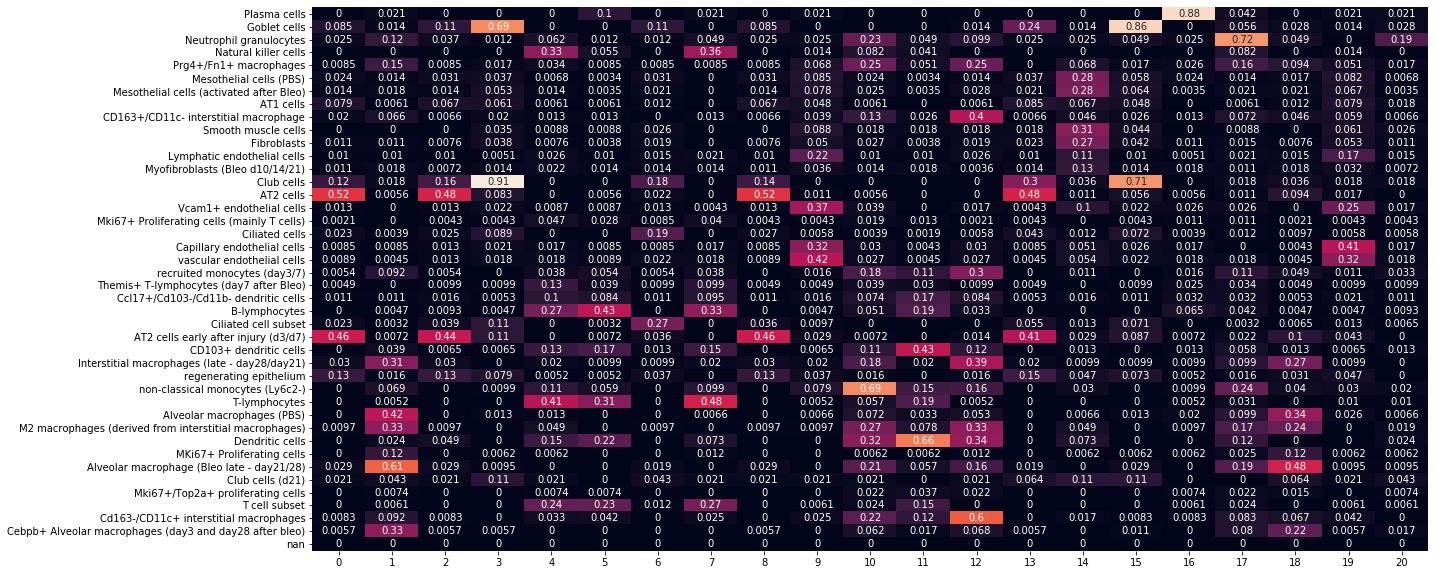

In [11]:
## Look at a predefined list of cell types and the corresponding marker genes in order to annotate our clusters
cell_annotation = sc.tl.marker_gene_overlap(adata, marker, key = 'rank_genes_groups', normalize = 'reference')

fig, ax = plt.subplots(figsize = (20, 10))  ## change figure size here
sb.heatmap(cell_annotation, cbar = False, annot = True)

... storing 'cell_type' as categorical


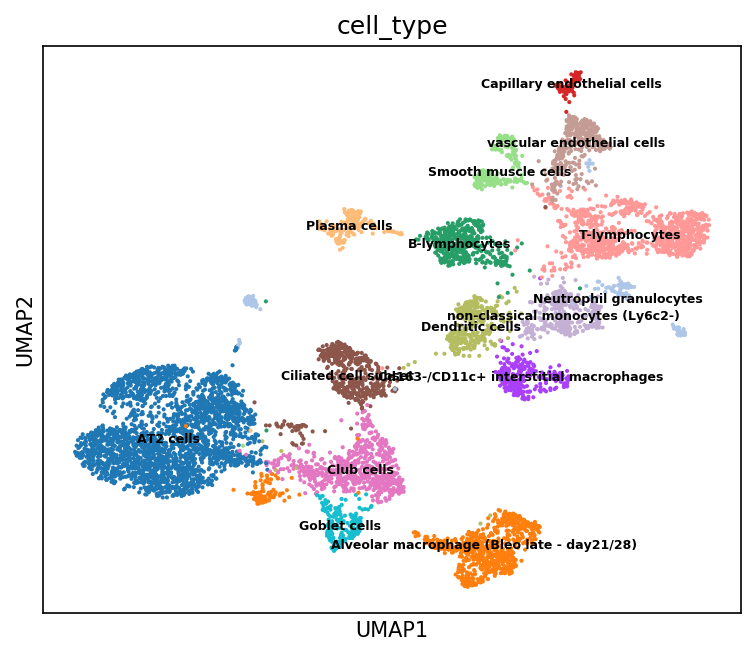

In [12]:
cell_type = dict()
for col in cell_annotation.columns:
    cell_type[col] = cell_annotation.index.values[np.argmax(cell_annotation.loc[:, col])]
    
## Alternatively, manually set cell types dictionary
#  cell_type = {'0': 'Type_2_pneumocytes', '1': 'Alveolar_macrophage', '2': 'Type_2_pneumocytes',
#               '3': 'Club_cells', '4': 'Cd4+_T_cells', '5': 'B_cells', '6': 'Ciliated_cells', etc...}

adata.obs["cell_type"] = [cell_type[cluster] for cluster in adata.obs["louvain"]]
sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", ax = mysize(6, 5, 150), legend_fontsize = 6)

As you can see, there are already some differences, so better only use these automated methods for coarse-grained annotation, but go in an manually set the cell types for the final annotation